Simple GAN using fully connected layers

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
* 2020-11-01: Initial coding
* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version


Source: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/1.%20SimpleGAN/fc_gan.py

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from matplotlib import pyplot

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [11]:
# Hyperparameters etc.
device = "cuda:1" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64 # 128, 256
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 3

In [7]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # transforms.Normalize((0.1307,), (0.1307,)),
    ]
)

In [8]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

In [34]:
Dreal_hist, Dfake_hist, G_hist, Areal_hist, Afake_hist = list(), list(), list(), list(), list()

In [35]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        
        Dreal_hist.append(lossD_real)
        Dfake_hist.append(lossD_fake)
        
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        G_hist.append(lossG)
        
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/3] Batch 0/1875                       Loss D: 0.6028, loss G: 0.9739
Epoch [1/3] Batch 0/1875                       Loss D: 0.8398, loss G: 0.9395
Epoch [2/3] Batch 0/1875                       Loss D: 0.4730, loss G: 1.8802


In [36]:
# create a line plot of loss for the gan and save to file
def plot_history(Dreal_hist, Dfake_hist, G_hist): #, aR_hist, aF_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(Dreal_hist, label='d-real')
	pyplot.plot(Dfake_hist, label='d-fake')
	pyplot.plot(G_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	# pyplot.subplot(2, 1, 2)
	# pyplot.plot(a1_hist, label='acc-real')
	# pyplot.plot(a2_hist, label='acc-fake')
	# pyplot.legend()
	# # save plot to file
	# pyplot.savefig(FILE_PATH+'/results_opt/plot_line_plot_loss.png')
	# pyplot.close()

In [37]:
Dreal_hist = [t.cpu().detach().numpy() for t in Dreal_hist]
Dfake_hist = [t.cpu().detach().numpy() for t in Dfake_hist]
G_hist = [t.cpu().detach().numpy() for t in G_hist]

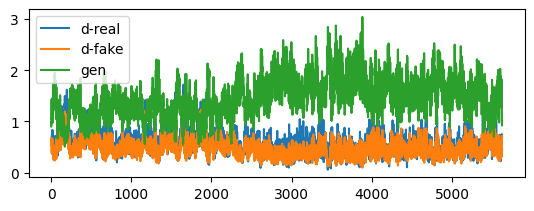

In [38]:
plot_history(Dreal_hist, Dfake_hist, G_hist)